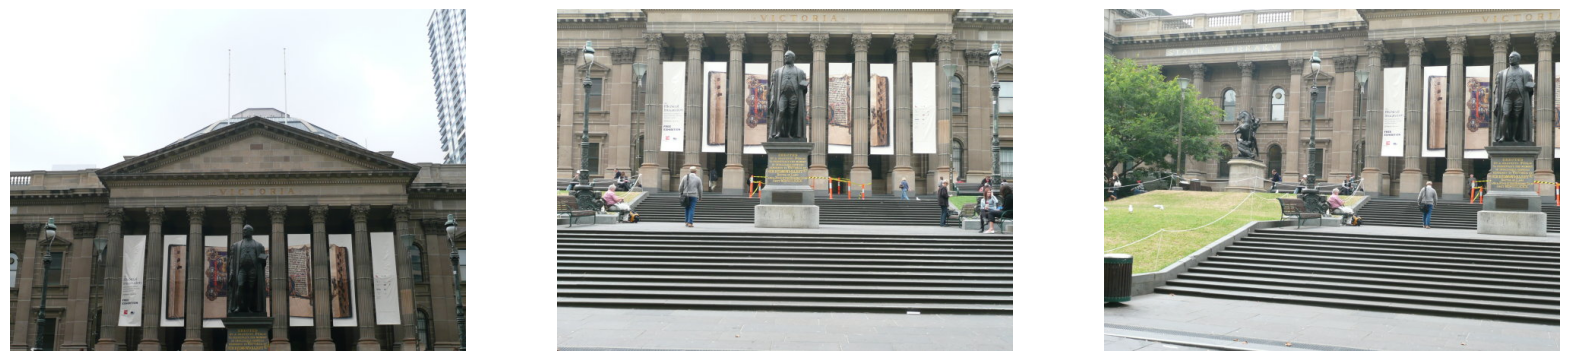

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import random 
"""
Read a set of images for Panorama stitching
"""
%matplotlib inline
path = '../images/set1/'
img1 = plt.imread(path+'1.jpg')
img2 = plt.imread(path+'2.jpg')
img3 = plt.imread(path+'3.jpg')

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.axis('off')
plt.imshow(img1)
plt.subplot(132)
plt.axis('off')
plt.imshow(img2)
plt.subplot(133)
plt.axis('off')
plt.imshow(img3)

In [2]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [3]:
def harris_corner(img):
    
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    Rs = cv2.cornerHarris(gray_img,2,3,0.04)
    m = Rs>0.01*Rs.max()
    corners = np.where(m)
    img[corners]=[255,0,0]

    return img,Rs


def anms(cimg,n_best):
    locmax = imregionalmax(cimg)
    locmaxcoord= np.transpose(np.nonzero(locmax)) 
    n_strong = len(locmax)
    r = [np.Infinity]*n_strong
    x=y=np.zeros((n_strong,1))
    ed=0
    for i in range(n_strong):
        for j in range(n_strong):
            if(cimg[locmaxcoord[j][0],locmaxcoord[j][1]] > cimg[locmaxcoord[i][0],locmaxcoord[i][1]]):
                ed = (locmaxcoord[j][0]-locmaxcoord[i][0])**2 + (locmaxcoord[j][1]-locmaxcoord[i][1])**2
            if ed<r[i]:
                r[i] = ed
                x[i] = locmaxcoord[i][0]
                y[i] = locmaxcoord[i][1]
    return x[:n_best],y[:n_best]


afterharris1,map1= harris_corner(img1.copy())
x1,y1 = anms(map1,10)


afterharris2,map2 = harris_corner(img2.copy())
x2,y2 = anms(map2,10)


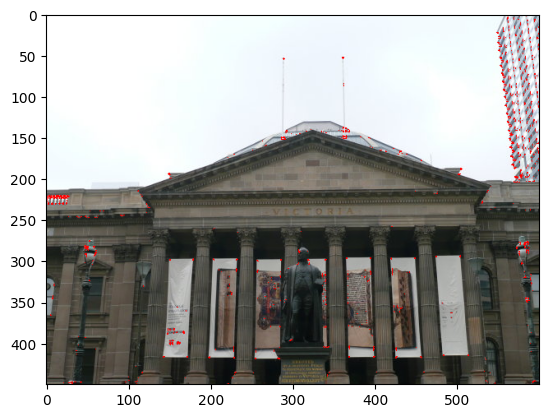

In [4]:
plt.imshow(afterharris1)

In [5]:
def drawpoints(img,x,y):
    for i in range(len(x)):
        cv2.circle(img,(int(y[i]),int(x[i])),3,255,-1)

drawpoints(afterharris1,x1,y1)
drawpoints(afterharris2,x2,y2)

/var/folders/4v/9y1hyv_91bx17wj1jzlqvwg40000gn/T/ipykernel_2012/2501920642.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.circle(img,(int(y[i]),int(x[i])),3,255,-1)


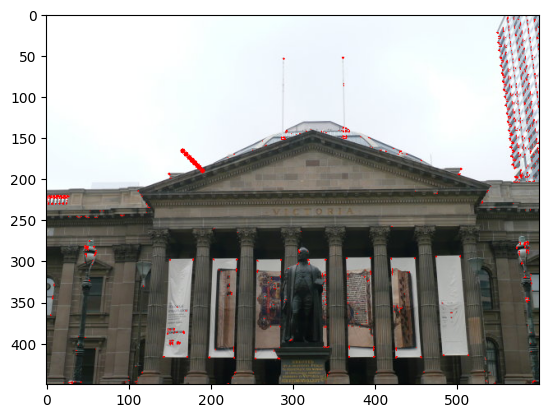

In [6]:
plt.imshow(afterharris1)

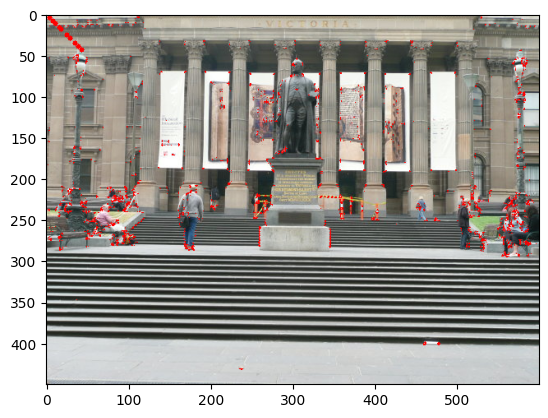

In [7]:
plt.imshow(afterharris2)

/var/folders/4v/9y1hyv_91bx17wj1jzlqvwg40000gn/T/ipykernel_2012/4193783640.py:1: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  x1 = np.int0(x1.reshape(1,len(x1)))[0]
/var/folders/4v/9y1hyv_91bx17wj1jzlqvwg40000gn/T/ipykernel_2012/4193783640.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  x2 = np.int0(x2.reshape(1,len(x2)))[0]
/var/folders/4v/9y1hyv_91bx17wj1jzlqvwg40000gn/T/ipykernel_2012/4193783640.py:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  y1 = np.int0(y1.reshape(1,len(y1)))[0]
/var/folders/4v/9y1hyv_91bx17wj1jzlqvwg40000gn/T/ipykernel_2012/4193783640.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  y2 = np.int0(y2.reshape(1,len(y2)))[0]


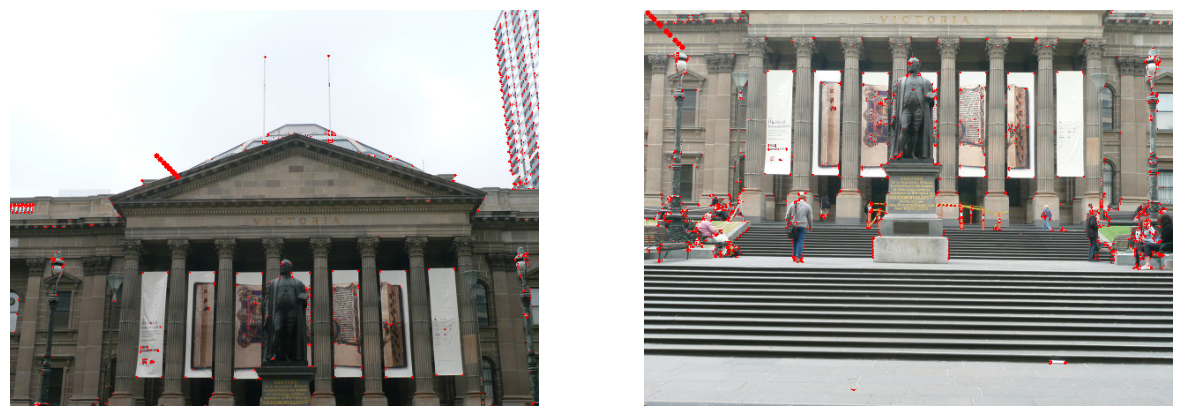

In [8]:
x1 = np.int0(x1.reshape(1,len(x1)))[0]
x2 = np.int0(x2.reshape(1,len(x2)))[0]
y1 = np.int0(y1.reshape(1,len(y1)))[0]
y2 = np.int0(y2.reshape(1,len(y2)))[0]

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.axis('off')
plt.imshow(afterharris1)
plt.subplot(122)
plt.axis('off')
plt.imshow(afterharris2)

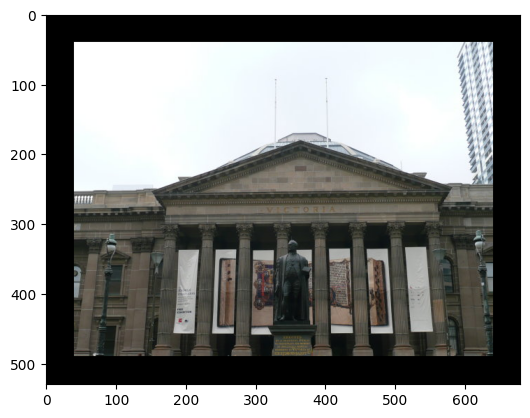

In [9]:
def feature_descriptors(image, keypts):
    descriptors = []

    for x_coord, y_coord in zip(*keypts):
        x_start = max(x_coord- 20, 0)
        x_end = min(x_coord+ 20, image.shape[1])
        y_start = max(y_coord- 20, 0)
        y_end = min(y_coord+ 20, image.shape[0])

        area = image[y_start:y_end, x_start:x_end]
        blurred = cv2.GaussianBlur(area, (3, 3), 0)
        resize = cv2.resize(blurred, (8, 8))
        flatten = resize.flatten().reshape(-1, 1)
        mean_val, std_val = np.mean(flatten), np.std(flatten)
        standardized = (flatten-mean_val)/(std_val if std_val> 0 else 1)
        descriptors.append(standardized)
    return descriptors

features1,patch1 = feature_des(img1,x1,y1)
# features2,patch2 = feature_des(img2,x2,y2)

In [10]:
def feature_match(features1,features2,x1,y1,x2,y2,img1,img2):
    features1 = np.array(features1,dtype='float32')
    features2 = np.array(features2,dtype='float32')

    bf = cv2.BFMatcher()
    rawMatches = bf.knnMatch(features1,features2,2)


    matches = []
    good = []
    c=0
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.90:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            good.append([m[0]])
            c = c+1

    print(c)
    corners1 = []
    corners2 = []
    for i in range(len(x1)):
        corners1.append([x1[i],y1[i]])

    for i in range(len(x2)):
        corners2.append([x2[i],y2[i]])

    pts1 = np.float32(corners1)
    pts2 = np.float32(corners2)
    pts1 = np.reshape(pts1,(len(x1),2))
    pts2 = np.reshape(pts2,(len(x2),2))

    kp1=[]
    kp2=[]
    for i in range(len(pts1)):
        kp1.append(cv2.KeyPoint(pts1[i][1], pts1[i][0], 5))
        kp2.append(cv2.KeyPoint(pts2[i][1], pts2[i][0], 5))

    img = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

    plt.figure(figsize=(15,15))
    plt.imshow(img)


    c = 0
    pts1f = []
    pts2f = []

    pts1t = []
    pts2t = []


    for mat in good:
        pts1f.append([kp1[mat[0].queryIdx].pt[1],kp1[mat[0].queryIdx].pt[0]])
        pts2f.append([kp2[mat[0].trainIdx].pt[1],kp2[mat[0].trainIdx].pt[0]])
        pts1t.append([kp1[mat[0].queryIdx].pt[0],kp1[mat[0].queryIdx].pt[1]])
        pts2t.append([kp2[mat[0].trainIdx].pt[0],kp2[mat[0].trainIdx].pt[1]])

    pts1f = np.float32(np.reshape(pts1f,(len(pts1f),2)))
    pts2f = np.float32(np.reshape(pts2f,(len(pts2f),2)))
    pts1t = np.float32(np.reshape(pts1t,(len(pts1t),2)))
    pts2t = np.float32(np.reshape(pts2t,(len(pts2t),2)))

    return pts1f,pts2f,pts1t,pts2t


In [11]:
def ransac(pts1, pts2, N=10, t=0.35, thresh=10):

    totalPoints = len(pts1)

    bestH = np.zeros((3,3))
    maxInliers = 0
    
    for j in range(N):
        index = []
        randFour = [np.random.randint(0,totalPoints) for i in range(4)]
        p1 = pts1[randFour]
        p2 = pts2[randFour]
        H = cv2.getPerspectiveTransform( np.float32(p1), np.float32(p2) )
        inLiers = 0
        for ind in range(totalPoints):
            source = pts1[ind]
            target = np.array([pts2[ind][0],pts2[ind][1]])
            pred = np.dot(H, np.array([source[0],source[1],1]))
#             print(pred[2])
            predx = pred[0]/pred[2]
            predy = pred[1]/pred[2]
            pred = np.array([predx,predy])
            pred = np.float32([point for point in pred])
            if np.linalg.norm(target-pred) < thresh:
                inLiers += 1
                index.append(ind)

        if maxInliers < inLiers:
            maxInliers = inLiers
            bestH = H
            if inLiers > t*totalPoints:
                break
    return bestH,index


In [12]:
pts1f,pts2f,pts1t,pts2t = feature_match(features1,features2,x1,y1,x2,y2,img1,img2)
H,index = ransac(pts1t,pts2t)
print(len(index))

pts1n = []
pts2n = []
x1n=[]
x2n=[]
y1n=[]
y2n=[]
for i in index:
    pts1n.append(pts1f[i])
    x1n.append(np.int0(pts1f[i][0]))
    y1n.append(np.int0(pts1f[i][0]))
    pts2n.append(pts2f[i])
    x2n.append(np.int0(pts2f[i][0]))
    y2n.append(np.int0(pts2f[i][0]))
    
H = np.float64([pt for pt in H])
print(H)

result = cv2.warpPerspective(img1, H,(img1.shape[1], img1.shape[0]))
plt.figure(figsize=(15,15))
plt.imshow(result)


features1,patch1 = feature_des(img1,x1n,y1n)
features2,patch2 = feature_des(img2,x2n,y2n)
pts1f,pts2f,pts1t,pts2t = feature_match(features1,features2,x1n,y1n,x2n,y2n,img1,img2)
features1 = np.array(features1,dtype='float32')
features2 = np.array(features2,dtype='float32')




NameError: name 'features2' is not defined